# MNIST Classification with CNN -- Low Level API (tf.nn) --
In this notebook, I describe how to implement CNN using tf.nn API.

In [1]:
import tensorflow as tf
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline

print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("scikit learn version: ", sklearn.__version__)
print("matplotlib version: ", matplotlib.__version__)

tensorflow version:  1.15.2
numpy version:  1.18.2
scikit learn version:  0.22.2.post1
matplotlib version:  3.2.0


## 1. Load data & preprocessing

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Split original training dataset into train/validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

In [4]:
# Normalize Intensity
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

In [5]:
# Convert into 4d tensor shape
X_train = X_train.reshape((*X_train.shape, 1))
X_val = X_val.reshape((*X_val.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))

In [6]:
# Convert labels into one-hot encoding (float)
y_train = np.float32(tf.keras.utils.to_categorical(y_train))
y_val = np.float32(tf.keras.utils.to_categorical(y_val))
y_test = np.float32(tf.keras.utils.to_categorical(y_test))

## 2. Create CNN model

Network structure:
[CONV(32) - BN - RELU] - MAXPOOL - [CONV(64) - BN - RELU] - MAXPOOL - [FC(1024) - BN - RELU] - DROPOUT - FC(10) - SOFTMAX

where the kernel size of the CONV layers are (3,3). In this notebook, I mainly use tf.nn class. The example of using tf.layers class is shown in another notebook. 
Note that tf.nn.conv2 function requires tensor shape of input and weight matrix like following:
>Given an input tensor of shape [batch, in_height, in_width, in_channels] and a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels], this op performs the following:

### Define layers

In [7]:
# CONV. layer w/o activation
def conv2d(x, W, b, strides=1, padding='SAME'):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return x

# Maxpooling layer
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

### Define network

In [8]:
class ConvNet():
    def __init__(self, weights, biases):
        """
        # Arguments
            weights : dictionary of the tf.Variable
            biases : dictionary of the tf.Variable
        """
        self.weights = weights
        self.biases = biases
    
    def __call__(self, x, dropout_rate, is_training):
        """
        # Arguments:
            x : (tf.placeholder) - features
            dropout_rate : (tf.placeholder) - dropout rate
            is_training : (tf.placeholder) - flag whether is training or not
        """
        # CONV - BN - RELU - POOL 28x28x1 to 14x14x32
        conv1 = conv2d(X, weights['W_CONV1'], biases['b_CONV1'])
        conv1 = tf.layers.batch_normalization(conv1, training=is_training)
        conv1 = tf.nn.relu(conv1)
        pool1 = maxpool2d(conv1)

        # CONV - BN - RELU - POOL 14x14x32 to 7x7x64
        conv2 = conv2d(pool1, weights['W_CONV2'], biases['b_CONV2'])
        conv2 = tf.layers.batch_normalization(conv2, training=is_training)
        conv2 = tf.nn.relu(conv2)
        pool2 = maxpool2d(conv2)

        # Flattern  7x7x64 to (7x7x64,)
        fl1 = tf.layers.flatten(pool2)

        # FC (7x7x64,) to 1x1024
        dense1 = tf.add(tf.matmul(fl1, weights['W_DENSE1']), biases['b_DENSE1'])
        dense1 = tf.layers.batch_normalization(dense1, training=is_training)
        dense1 = tf.nn.relu(dense1)

        drop1 = tf.nn.dropout(dense1, rate=dropout_rate)

        # 1x1024 to 1x10
        dense2 = tf.add(tf.matmul(drop1, weights['W_DENSE2']), biases['b_DENSE2'])
        return dense2   

The shape of the weights and the biases are following:
- W_CONV1 : [3, 3, 1, 32]
- W_CONV2 : [3, 3, 32, 64]
- W_DENCE1 : [7x7x64, 1024]
- W_DENCE2 : [1024, n_class]
- b_CONV1 : [32,]
- b_CONV2 : [64,]
- b_DENSE1 : [1024,]
- b_DENSE2 : [n_class]

The weight initialization rule are following:  
- Layer with relu activation: He initialization  
- Others: Xavier initialization  

### Build graph

In [9]:
# Remove the privious graph
tf.reset_default_graph()

# parameter setting
n_class = 10
img_width = img_height = 28
img_depth = 1

# Define initializer
he_initializer = tf.initializers.he_normal()
xavier_initializer = tf.initializers.glorot_normal()

# Define weights & biases
weights ={
    'W_CONV1' : tf.get_variable("W_CONV1", shape=[3, 3, 1, 32], initializer=he_initializer),
    'W_CONV2' : tf.get_variable("W_CONV2", shape=[3, 3, 32, 64], initializer=he_initializer),
    
    'W_DENSE1' : tf.get_variable("W_DENSE1", shape=[7*7*64, 1024], initializer=he_initializer),
    'W_DENSE2' : tf.get_variable("W_DENSE2", shape=[1024, n_class], initializer=he_initializer),
}
biases = {
    'b_CONV1' : tf.Variable(tf.zeros([32,])),
    'b_CONV2' : tf.Variable(tf.zeros([64,])),
    
    'b_DENSE1' : tf.Variable(tf.zeros([1024,])),
    'b_DENSE2' :  tf.Variable(tf.zeros([n_class,])),
}

# Add placeholder
X = tf.placeholder(tf.float32, shape=[None, img_height, img_width, img_depth])
y = tf.placeholder(tf.float32, shape=[None, n_class])
lr = tf.placeholder(tf.float32)
dropout_rate = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool)

# add logits ops
logits = ConvNet(weights, biases)(X, dropout_rate, is_training)

# add loss & optimizer ops
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(cost)

# add accuracy ops
correct_pred = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# ops for debug
predict_class = tf.argmax(logits, axis=1)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Debug

In [10]:
def visualize_batch(X_batch, y_batch, y_pred=None):
    assert len(X_batch) == len(y_batch)
    
    n_col = 10
    if len(X_batch) % n_col ==0:
        n_row=len(X_batch)//n_col
    else:
        n_row=len(X_batch)//n_col + 1
    
    fig = plt.figure(figsize=(20,15))
    
    for idx in range(len(y_batch)):
        if y_pred is not None:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}, pred={}".format(np.argmax(y_batch[idx]), y_pred[idx]))
        else:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}".format(np.argmax(y_batch[idx])))
        ax.imshow(X_batch[idx].reshape(28,28), cmap='gray')
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    plt.show()

In [11]:
batch_size = 8

# initialize parameters
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    rand_index = np.random.choice(X_train.shape[0], size=batch_size)
    
    X_batch = X_train[rand_index]
    y_batch = y_train[rand_index]
    
    learning_rate = 0.001
    
    sess.run(train_op, feed_dict={
        X : X_batch,
        y : y_batch,
        lr : learning_rate,
        dropout_rate : 0.5,
        is_training : True
    })
    
    # this calc. is just a debug
    logit, train_pradict_class = sess.run([logits, predict_class], feed_dict={
        X : X_batch,
        y : y_batch,
        lr : learning_rate,
        dropout_rate : 0.5,
        is_training : True
    })
    
    train_loss = sess.run(cost, feed_dict={
        X : X_batch,
        y : y_batch,
        lr : learning_rate,
        dropout_rate : 0.4,
        is_training : True
    })
    train_acc = sess.run(accuracy, feed_dict={
        X : X_batch,
        y : y_batch,
        lr : learning_rate,
        dropout_rate : 0.,
        is_training : True
    })
    
    print('****** true label ******')
    print(y_batch)
    print('****** logits ******')
    print(logit)
    print('****** predict class ******')
    print(train_pradict_class)
    
    print('****** train_loss ******')
    print(train_loss)
    print('****** train_acc ******')
    print(train_acc)

****** true label ******
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
****** logits ******
[[ 6.3537054   1.0882548  -1.6725295  -3.124223   -0.21068369 -1.6669766
  -2.6214564  -0.3079822   0.6790353  -1.3311512 ]
 [-2.5361495  -0.25544155 -2.0411987  -1.2997248   0.41235787  5.1229157
  -1.6024036  -1.1598403  -1.271985   -2.0685039 ]
 [-2.3150709   1.7152882  -0.851214   -0.75011164  6.554558    0.5716191
  -2.527921   -2.470919   -0.42402717 -1.8542842 ]
 [-0.07172005 -0.3763085  -3.620453    6.502494    1.1451825  -0.50777656
  -1.2442759   0.75645    -1.5946612  -1.9941502 ]
 [ 6.0688653  -2.2060962  -0.79425025 -0.91604173 -1.6899508  -1.4756345
   0.12812366  0.79489684 -1.2446381   0.24149014]
 [-2.3632317   0.7078739   0.12565404 -1.8694534   0.08707764 -1.388

## 3. Training

In [12]:
batch_size = 64

### Dataset

In [13]:
# Build source dataset for training
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset)).batch(batch_size)

# Build source dataset for validation
X_valid_dataset = tf.data.Dataset.from_tensor_slices(X_val)
y_valid_dataset = tf.data.Dataset.from_tensor_slices(y_val)
validation_dataset = tf.data.Dataset.zip((X_valid_dataset, y_valid_dataset)).batch(batch_size)

# Build source dataset for test
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset)).batch(batch_size)

# Make iterator from dataset structure (re-use)
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)

# Define ops for batch generation
next_data = iterator.get_next()

# Define initialize ops
train_iter_init = iterator.make_initializer(train_dataset)
validation_iter_init = iterator.make_initializer(validation_dataset)
test_iter_init = iterator.make_initializer(test_dataset)

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.


### Training

In [14]:
# Session
epochs = 15
drop_rate = 0.2
learning_rate = 0.001

# difine checkpoint file name
checkpoint_path = './checkpoints_1'

saver = tf.train.Saver()
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    not_improved_cnt = 0
    val_loss_best = 99999999
    
    # Training cycle
    for epoch in range(epochs):
        
        start = time.time()
        train_loss_list = []
        train_acc_list = []
        validation_loss_list = []
        validation_acc_list = []
        
        # train
        sess.run(train_iter_init)
        while True:
            try:
                X_batch, y_batch = sess.run(next_data)
                
                feed_dict={
                    X : X_batch,
                    y : y_batch,
                    lr : learning_rate,
                    dropout_rate : drop_rate,
                    is_training : True
                }
                
                # update trainable weights
                sess.run(train_op, feed_dict=feed_dict)
                
                # calc. train loss & accuracy per batch
                train_loss, train_acc = sess.run([cost, accuracy], feed_dict=feed_dict)
                
                train_loss_list.append(train_loss)
                train_acc_list.append(train_acc)
            except tf.errors.OutOfRangeError:
                break
        
        # validation
        sess.run(validation_iter_init)
        while True:
            try:
                X_batch, y_batch = sess.run(next_data)
                # calc. validation loss & acc 
                val_loss, val_acc = sess.run([cost, accuracy], feed_dict={
                    X : X_batch,
                    y : y_batch,
                    lr : learning_rate,
                    dropout_rate : 0.0,
                    is_training : False
                })
                validation_loss_list.append(val_loss)
                validation_acc_list.append(val_acc)
            except tf.errors.OutOfRangeError:
                break
        elapsed_time = time.time() - start
        
        # Average over dataset
        train_loss = np.average(train_loss_list)
        train_acc = np.average(train_acc_list)
        val_loss = np.average(validation_loss_list)
        val_acc = np.average(validation_acc_list)
        
        print('epoch {0}, time_per_epoch={1:.1f} s, loss={2:.4f}, acc={3:.2f}, val_loss={4:.4f}, val_acc={5:.2f}'
              .format(epoch, elapsed_time, train_loss, train_acc, val_loss, val_acc))
        
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            
            # reset count
            not_improved_cnt = 0
            
            saver.save(sess, '{}/model_{}.ckpt'.format(checkpoint_path, epoch))
            print('val_loss improved -- Trained Model Saved')
        else:
            not_improved_cnt += 1
            print('val_loss not improved')
            
            if not_improved_cnt >= 3:
                print('val_loss not improved -- Stop training session')
                break

epoch 0, time_per_epoch=36.0 s, loss=0.0673, acc=0.98, val_loss=0.0691, val_acc=0.98
val_loss improved -- Trained Model Saved
epoch 1, time_per_epoch=34.1 s, loss=0.0210, acc=0.99, val_loss=0.0785, val_acc=0.98
val_loss not improved
epoch 2, time_per_epoch=34.0 s, loss=0.0094, acc=1.00, val_loss=0.0623, val_acc=0.98
val_loss improved -- Trained Model Saved
epoch 3, time_per_epoch=34.0 s, loss=0.0064, acc=1.00, val_loss=0.0616, val_acc=0.98
val_loss improved -- Trained Model Saved
epoch 4, time_per_epoch=34.0 s, loss=0.0044, acc=1.00, val_loss=0.0533, val_acc=0.99
val_loss improved -- Trained Model Saved
epoch 5, time_per_epoch=34.0 s, loss=0.0044, acc=1.00, val_loss=0.0429, val_acc=0.99
val_loss improved -- Trained Model Saved
epoch 6, time_per_epoch=33.9 s, loss=0.0034, acc=1.00, val_loss=0.0635, val_acc=0.99
val_loss not improved
epoch 7, time_per_epoch=33.9 s, loss=0.0025, acc=1.00, val_loss=0.0579, val_acc=0.99
val_loss not improved
epoch 8, time_per_epoch=33.9 s, loss=0.0027, acc=

## 4. Test

INFO:tensorflow:Restoring parameters from checkpoints/model_8.ckpt


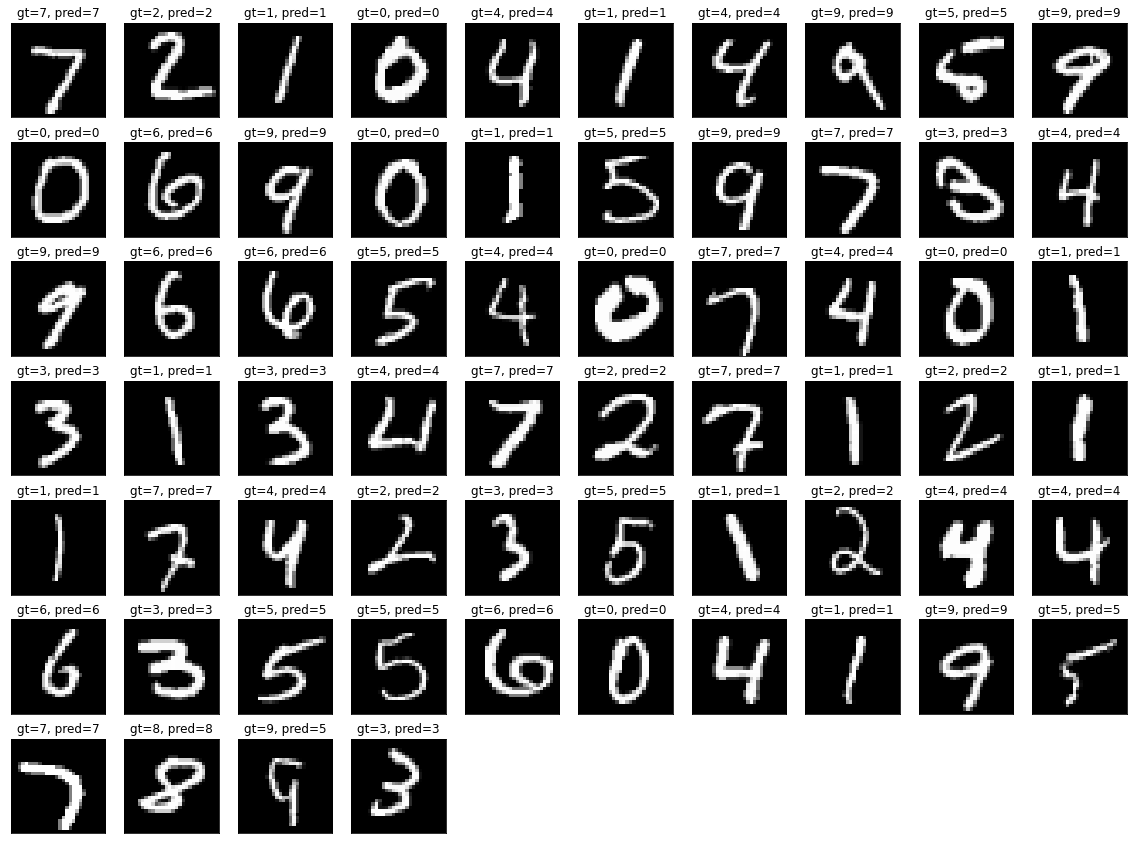

test_acc=1.000


In [15]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_path))
    
    test_loss_list = []
    test_acc_list = []
    
    sess.run(test_iter_init)

    # evaluate
    cnt = 0
    while True:
        try:
            X_batch, y_batch = sess.run(next_data)
            
            # calc. test loss & acc 
            pred_labels, test_acc = sess.run([predict_class, accuracy], feed_dict={
                X : X_batch,
                y : y_batch,
                lr : learning_rate,
                dropout_rate : 0.0,
                is_training : False
            })
            
            if cnt % 500 == 0:
                visualize_batch(X_batch, y_batch, pred_labels)
            test_acc_list.append(test_acc)
            
            cnt += 1
        except tf.errors.OutOfRangeError:
            break
            
    test_acc = np.average(test_acc)

    print('test_acc={0:.3f}'.format(test_acc))